# Dependencies

In [1]:
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torchvision.models.feature_extraction import create_feature_extractor

from torchsummary import summary

from torchmetrics import Accuracy

import matplotlib.pyplot as plt

In [2]:
# set a fixed seed
random_state = 42
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
np.random.seed(random_state)

In [3]:
# check if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Dataset

In [4]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(dtype= torch.float32, scale= True),
        v2.Normalize(mean= (0.5,), std= (0.5,))
    ]
)

trainset = CIFAR10('./dataset', train= True , transform= transform, download= True)
testset  = CIFAR10('./dataset', train= False, transform= transform, download= True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = np.array(trainset.classes)
num_classes = len(classes)
num_trainset, height, width, depth = trainset.data.shape

In [6]:
batch_size = 128
trainloader = DataLoader(trainset, batch_size= batch_size, shuffle= True , num_workers= 2)
testloader  = DataLoader(trainset, batch_size= batch_size, shuffle= False, num_workers= 2)

# Model

In [7]:
class CustomModel(nn.Module):
    def __init__(self, layers):
        super(CustomModel, self).__init__()

        feature_extractor_layers = []
        for i, o in zip(layers, layers[1:]):
            feature_extractor_layers.append(nn.Conv2d(i, out_channels= o, kernel_size= 3))
            feature_extractor_layers.append(nn.BatchNorm2d(o))
            feature_extractor_layers.append(nn.ReLU())
            feature_extractor_layers.append(nn.MaxPool2d(kernel_size= 2))

        self.feature_extractor = nn.Sequential(*feature_extractor_layers)
        self.flatten = nn.Flatten(start_dim= 1)
        self.classifier = nn.Linear(1152, len(classes))
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

model = CustomModel(layers= [depth, 16, 32])

model.to(device)

CustomModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=1152, out_features=10, bias=True)
)

In [8]:
summary(model, input_size= testset.data.transpose(0, 3, 1, 2).shape[1:], batch_size= batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 30, 30]             448
       BatchNorm2d-2          [128, 16, 30, 30]              32
              ReLU-3          [128, 16, 30, 30]               0
         MaxPool2d-4          [128, 16, 15, 15]               0
            Conv2d-5          [128, 32, 13, 13]           4,640
       BatchNorm2d-6          [128, 32, 13, 13]              64
              ReLU-7          [128, 32, 13, 13]               0
         MaxPool2d-8            [128, 32, 6, 6]               0
           Flatten-9                [128, 1152]               0
           Linear-10                  [128, 10]          11,530
Total params: 16,714
Trainable params: 16,714
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.50
Forward/backward pass size (MB): 63.81
Params size (MB): 0.06
Estimated To

# Set up remaining Hyper-Parameters

In [9]:
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params= model.parameters(), lr= lr)
num_epochs = 10

# Train Loop

In [10]:
train_acc_per_epoch  = []
train_loss_per_epoch = []
train_acc = Accuracy(task = 'multiclass', num_classes= len(testset.classes), top_k= 1).to(device)

In [11]:
for epoch in range(num_epochs):

# train loop
    model.train()
    train_loss  = 0

    for x, y in trainloader:

        # send data to GPU
        x, y_true = x.to(device), y.to(device)

        # forward
        y_pred = model(x)
        loss = criterion(y_pred, y_true)

        # backward
        loss.backward()

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

        # log loss & accuracy
        train_loss += loss.item() * len(x)
        train_acc.update(y_pred, y_true)

    train_loss_per_epoch.append(train_loss / len(trainset))
    train_acc_per_epoch.append(train_acc.compute().item())
    train_acc.reset()

    # log
    print(f"epoch {epoch:>1}  ->  train[loss: {train_loss_per_epoch[epoch]:.5f} - acc: {train_acc_per_epoch[epoch]:.2f}]")


epoch 0  ->  train[loss: 1.48925 - acc: 0.49]
epoch 1  ->  train[loss: 1.10499 - acc: 0.61]
epoch 2  ->  train[loss: 0.99465 - acc: 0.66]
epoch 3  ->  train[loss: 0.93405 - acc: 0.68]
epoch 4  ->  train[loss: 0.88761 - acc: 0.69]
epoch 5  ->  train[loss: 0.85966 - acc: 0.70]
epoch 6  ->  train[loss: 0.83669 - acc: 0.71]
epoch 7  ->  train[loss: 0.81544 - acc: 0.72]
epoch 8  ->  train[loss: 0.79761 - acc: 0.72]
epoch 9  ->  train[loss: 0.78995 - acc: 0.73]


# Feature Extraction

In [19]:
for name, param in model.named_parameters():
    print(f"{name:<26} - requires_grad: {param.requires_grad}")

feature_extractor.0.weight - requires_grad: True
feature_extractor.0.bias   - requires_grad: True
feature_extractor.1.weight - requires_grad: True
feature_extractor.1.bias   - requires_grad: True
feature_extractor.4.weight - requires_grad: True
feature_extractor.4.bias   - requires_grad: True
feature_extractor.5.weight - requires_grad: True
feature_extractor.5.bias   - requires_grad: True
classifier.weight          - requires_grad: True
classifier.bias            - requires_grad: True


In [13]:
nodes = {
    "feature_extractor.0": "conv1",
    "feature_extractor.5": "conv2"
}

feature_extractor = create_feature_extractor(model, return_nodes= nodes)

In [14]:
frog = transform(testset.data[0]).to(device)[None, :, :, :]

feature_maps = feature_extractor(frog)
feature_maps.keys()

dict_keys(['conv1', 'conv2'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


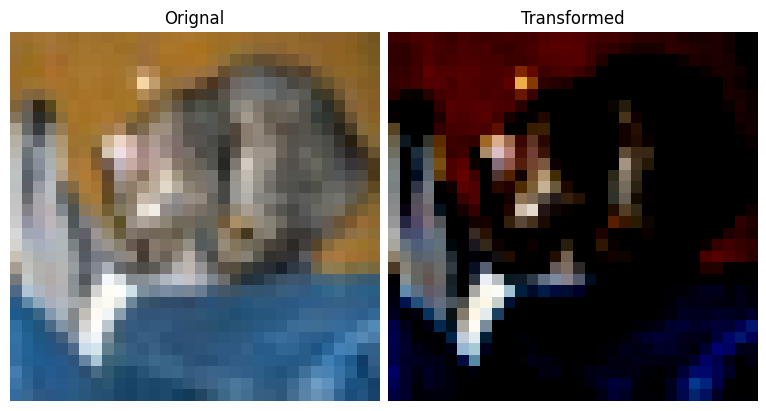

In [15]:
# plot
fig, axs = plt.subplots(nrows= 1, ncols= 2, figsize= (8, 4), layout= 'compressed')

axs[0].imshow(testset.data[0])
axs[0].axis('off')
axs[0].set_title('Orignal')
axs[1].imshow(frog.detach().cpu()[0].permute(1, 2, 0))
axs[1].axis('off')
axs[1].set_title('Transformed')

plt.show()

## model.feature_extractor.0
   - Feature maps : 16x30x30

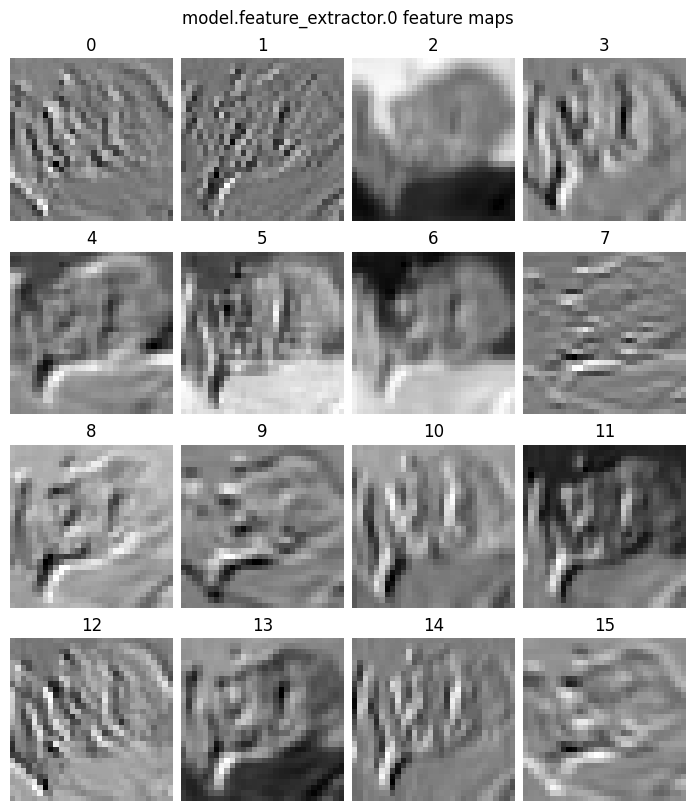

In [16]:
# plot
total_rows = 4
total_cols = 4

fig, axs = plt.subplots(nrows= total_rows, ncols= total_cols, figsize= (total_cols * 2, total_rows * 2), layout= 'compressed')
fig.suptitle('model.feature_extractor.0 feature maps')

for row in range(total_rows):
    for col in range(total_cols):
        axs[row, col].imshow(feature_maps['conv1'][0, row * total_cols + col].detach().cpu(), cmap= 'gray')
        axs[row, col].axis('off')
        axs[row, col].set(title= row * total_cols + col)

plt.show()

## model.feature_extractor.5
   - Feature maps : 32x13x13

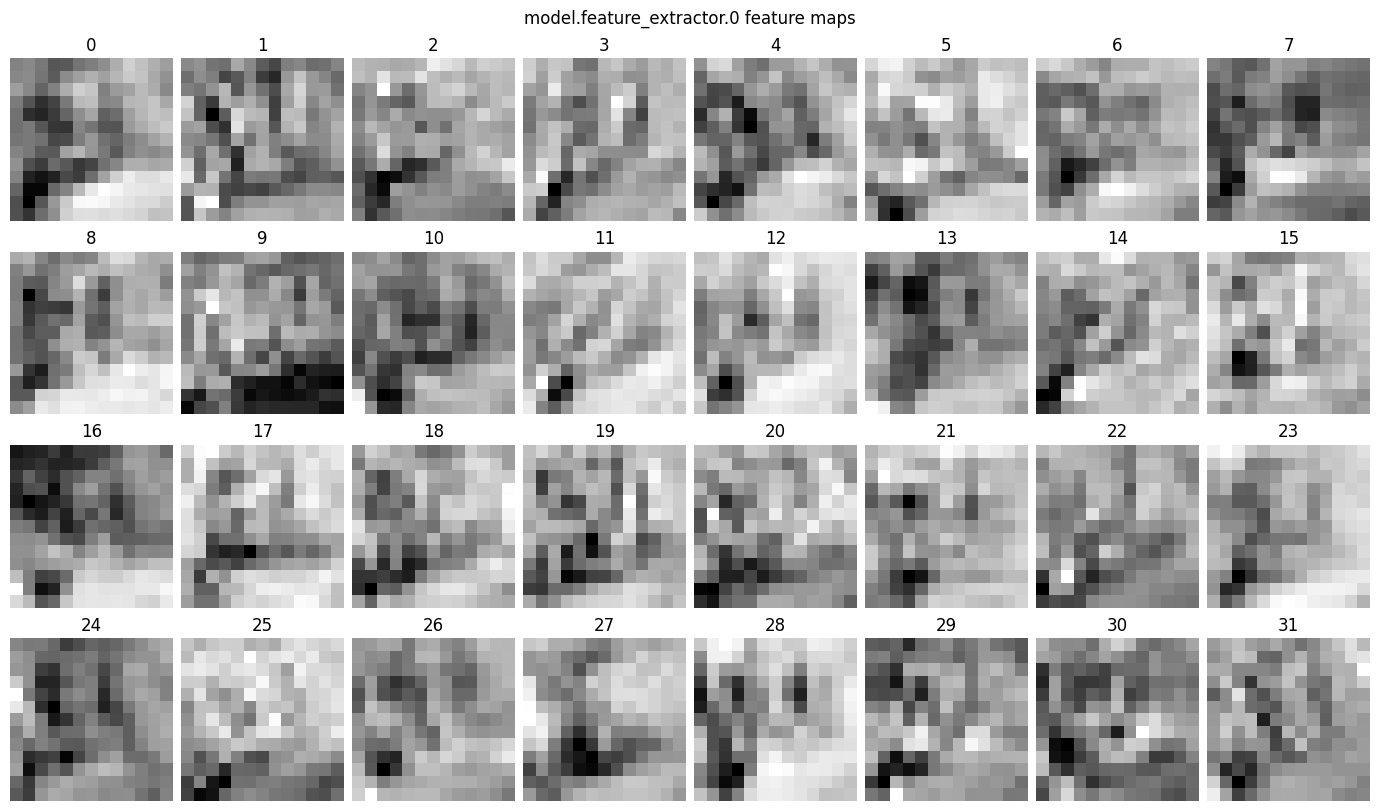

In [17]:
# plot
total_rows = 4
total_cols = 8

fig, axs = plt.subplots(nrows= total_rows, ncols= total_cols, figsize= (total_cols * 2, total_rows * 2), layout= 'compressed')
fig.suptitle('model.feature_extractor.0 feature maps')

for row in range(total_rows):
    for col in range(total_cols):
        axs[row, col].imshow(feature_maps['conv2'][0, row * total_cols + col].detach().cpu(), cmap= 'gray')
        axs[row, col].axis('off')
        axs[row, col].set(title= row * total_cols + col)

plt.show()